In [1]:
import numpy as np # type: ignore
import random
import copy
import matplotlib.pyplot as plt  # type: ignore

In [2]:
class Problem:
    def __init__(self, profit, times, weight, capacity):
        self.profit = profit
        self.times = times
        self.weight = weight
        self.capacity = capacity
    

In [3]:
def decode(chromosome):
    chr = chromosome.tolist()
    return [0.5 if gene < 0.5 else 1 for gene in chr]

def get_fitness(chromosome, problem : Problem):
    solution = decode(chromosome)
    total_profit = np.sum(solution * problem.profit)
    total_times = np.sum(solution * problem.times)
    total_weight = np.sum(solution * problem.weight)

    if total_weight > problem.capacity:
        return [1e9, 1e9]
    else:
        return [-total_profit, -total_times]

In [4]:
class Individual:
    def __init__(self):
        self.chromosome = None
        self.fitness = None

    def gen_indi(self, problem : Problem):
        num_item = problem.profit.size
        self.chromosome = np.random.uniform(0.0, 1.0, num_item)
    
    def cal_fitness(self, problem):
        self.fitness = get_fitness(self.chromosome, problem)

    def clone(self):
        return copy.deepcopy(self)
    
    def __lt__(self, other):
        return np.all(self.fitness <= other.fitness) and np.any(self.fitness < other.fitness)
    
    def __eq__(self, other):
        return np.all(decode(self.chromosome) == decode(other.chromosome))
    
    def __hash__(self):
        return hash(tuple(decode(self.chromosome)))
    
    def __repr__(self):
        return f"chromosome={self.chromosome}, fitness={self.fitness}" 


In [5]:
a = Individual()
b = Individual()
c = Individual()

a.chromosome = np.array([1, 2, 3])
b.chromosome = np.array([1, 2, 3])
c.chromosome = np.array([0, 2, 3])

arr = list(set([a, b, c]))

print(arr)



[chromosome=[0 2 3], fitness=None, chromosome=[1 2 3], fitness=None]


In [6]:
# Simulated binary crossover - SBX
def crossover(parent1, parent2, problem : Problem, eta = 2.0):
    off1 = Individual()
    off2 = Individual()
    r = np.random.rand()
    if (r <= 0.5):
        beta = (2*r)**(1.0/(eta + 1))
    else:
        beta = (1.0/(2*(1 - r)))**(1.0/(eta + 1))
    p1 = parent1.chromosome
    p2 = parent2.chromosome
    c1 = 0.5 * ((1 + beta) * p1 + (1 - beta) * p2)
    c2 = 0.5 * ((1 - beta) * p1 + (1 + beta) * p2)
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    off1.chromosome = c1
    off2.chromosome = c2
    return off1.clone(), off2.clone()

In [7]:

# Polynomial mutaion - PM
def mutation(indi, eta = 20.0):
    chr = indi.chromosome
    for i in range(chr.size):
        mu = np.random.rand()
        if (mu <= 0.5):
            delta = (2 * mu)**(1.0/(1 + eta)) - 1
            chr[i] = chr[i] + delta * chr[i]
        else:
            delta = 1 - (2 - 2*mu)**(1.0/(1 + eta))
            chr[i] = chr[i] + delta * (1 - chr[i])
            
    chr = np.clip(chr, 0.0, 1.0)
    indi.chromosome = chr
    return indi.clone()

In [8]:
class Population:
    def __init__(self, pop_size, problem : Problem):
        self.pop_size = pop_size
        self.list_indi = []
        self.problem = problem
    
    def genPop(self):
        for i in range(self.pop_size):
            indi = Individual()
            indi.gen_indi(self.problem)
            indi.cal_fitness(self.problem)
            self.list_indi.append(indi)


In [9]:
def selection(list, k = 4):
    tour1 = random.sample(list, k)
    tour2 = random.sample(list, k)
    x = min(tour1)
    y = min(tour2)
    return x.clone(), y.clone() 


In [10]:
def fast_nodominated_sort(pop: list):
    pn = np.zeros(len(pop), dtype=int)
    pS = []

    for i, p in enumerate(pop):
        Q = []
        for j, q in enumerate(pop):
            if i == j:
                continue
            if p < q:
                pn[j] += 1
                Q.append(j)
        pS.append(Q)

    paretos = [[i for i in range(len(pop)) if pn[i] == 0]]

    while True:
        next_pareto = []
        for i in paretos[-1]:
            for j in pS[i]:
                pn[j] -= 1
                if pn[j] == 0:
                    next_pareto.append(j)
        if len(next_pareto) == 0:
            break
        paretos.append(next_pareto)
    
    return [[pop[idx] for idx in pr] for pr in paretos]
    

In [11]:
def assign_crowding_distance(pop: list):
    if (len(pop) < 3):
        return pop
    indices = list(range(len(pop)))
    I = np.zeros(len(pop), dtype=float)

    for k in range(len(pop[0].fitness)):
        fk = [p.fitness[k] for p in pop]
        indices = np.argsort(fk)

        lim = fk[indices[-1]] - fk[indices[0]]
        if lim < 1e-4:
            return pop
        I[indices[0]] = I[indices[-1]] = 1e9

        for i in range(1, indices.size - 1):
            I[indices[i]] += (fk[indices[i + 1]] - fk[indices[i - 1]]) / lim
    
    indices = np.argsort(I)
    indices.reverse()
    new_pop = [pop[i] for i in indices]
    return new_pop


In [12]:

def survival_selection(list, pop_size):
    paretos = fast_nodominated_sort(list)
    for front in paretos:
        front = assign_crowding_distance(front)
    next_gen = []
    for front in paretos:
        for indi in front:
            next_gen.append(indi)
            pop_size -= 1
            if pop_size == 0:
                return next_gen
    if pop_size != 0:
        print("Error")
    return next_gen

In [13]:
def NSGAII(problem, pop_size, max_gen, p_c, p_m):
    pop = Population(pop_size, problem)
    pop.genPop()
    for i in range(max_gen):
        nextPop = []
        while (len(nextPop) < pop_size):
            p1, p2 = selection(pop.list_indi)
            c1 = Individual()
            c2 = Individual()
            if np.random.rand() <= p_c:
                c1, c2 = crossover(p1, p2, problem)
                c1.cal_fitness(problem)
                c2.cal_fitness(problem)
                nextPop.append(c1)
                nextPop.append(c2)
            if np.random.rand() <= p_m:
                p1 = mutation(p1)
                p2 = mutation(p2)
                p1.cal_fitness(problem)
                p2.cal_fitness(problem)
                nextPop.append(p1)
                nextPop.append(p2)
        pop.list_indi = survival_selection(nextPop, pop_size)
    paretos = fast_nodominated_sort(pop.list_indi)
    pareto_front = list(set(paretos[0]))
    return pareto_front

In [14]:
# setup
profit = np.random.uniform(5.0, 20.0, 10)
weight = np.random.uniform(2.0, 20.0, 10)
times = np.random.uniform(2.0, 15.0, 10)
capacity = np.random.uniform(0.0, np.sum(weight))
# profit = np.array([3, 6, 8, 10, 15])
# weight = np.array([2, 3, 3, 5, 8])
# capacity = 10
problem = Problem(profit, times, weight, capacity)

pop_size = 200
max_gen = 500
Pc = 0.8
Pm = 0.2

#start
solution = NSGAII(problem, pop_size, max_gen, Pc, Pm)


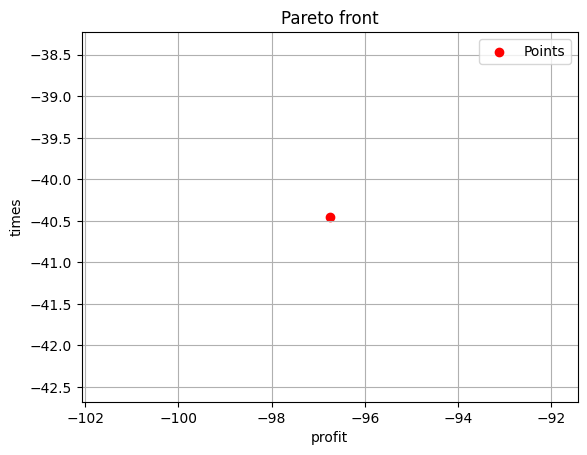

In [15]:

#show
point = np.array([p.fitness for p in solution])
x, y = point[:, 0], point[:, 1]

plt.scatter(x, y, color='red', marker='o', label="Points")
plt.xlabel("profit")
plt.ylabel("times")
plt.title("Pareto front")
plt.legend()
plt.grid(True)
plt.show()
